# Instructions
- Before running the jupyter notebook, don't forget to copy it into your drive **(`File` => `Save a copy in Drive`)**. *Failing to do this step may result in losing the progress of your code.*
- Change your resource type to GPU before progressing **(`Runtime` => `Change runtime time` => `T4 GPU`).**
- For the submission of the assignment, please download this notebook as a **Python file**, named `A2S2.py`.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# 2.1 Implementing Attention from Scratch

**NOTE: We'll grade this part of the code!**

## Preparation

In [2]:
######################################################
#  The following code is given to you.
######################################################

def MHA_wrapper(query, key, value, n_heads=1, causal=False):
    """
    This is a wrapper around the PyTorch implementation of multi-head attention.
    You will use this implementation to compare to your implementation for code testing.
    """
    assert query.shape == key.shape == value.shape
    _, n_tok, n_embd = query.shape

    query = query.transpose(0,1)
    key = key.transpose(0,1)
    value = value.transpose(0,1)

    in_proj_weight = torch.eye(n_embd, dtype=key.dtype, device=key.device).repeat((3, 1))
    out_proj_weight = torch.eye(n_embd, dtype=key.dtype, device=key.device)

    attn_mask = None
    if causal:
        attn_mask = torch.tril(torch.ones(n_tok, n_tok, dtype=bool, device=key.device)).logical_not()

    out, _ = F.multi_head_attention_forward(
        query, key, value, n_embd, n_heads,
        in_proj_weight=in_proj_weight, in_proj_bias=None,
        bias_k=None, bias_v=None, add_zero_attn=False, dropout_p=0,
        out_proj_weight=out_proj_weight, out_proj_bias=None,
        attn_mask=attn_mask, need_weights=False,)

    return out.transpose(0,1)

In [3]:
######################################################
#  The following code is given to you.
######################################################

# use cpu for now
DEVICE = torch.device("mps")

# make these bigger if you want a stricter test of your code
part1_n_tok = 10
part1_n_emb = 6

# generate fixed pseudo-random Q,K,V for testing attn function
torch.manual_seed(447)

# Initialize random testing Q,K,V
part1_key = torch.randn(1, part1_n_tok, part1_n_emb).to(DEVICE)
part1_value = torch.randn(1, part1_n_tok, part1_n_emb).to(DEVICE)
part1_query = torch.randn(1, part1_n_tok, part1_n_emb).to(DEVICE)

## Step 0: Set up the projections for attention.
**You will complete the following code blocks denoted by `TODO:`.**

In [4]:
def init_qkv_proj(n_embd:int):
    """
    This function is given to you.
    :return: A tuple of length 3 containing the projections for Q, K, V.
    """
    shared_proj = nn.Linear(n_embd, n_embd)
    return (shared_proj,shared_proj,shared_proj)


def self_attention(Q, K, V, n_heads=1, causal=True):
    """
    Self-attention block.

    Note: You will keep coming back to this cell and fill in more of this function
    after completing each of the following steps! Don't forget to re-run this
    cell each time you change it. Make sure that once you're done, all the testing
    cells should work.

    :return: A tensor containing the result of the self-attention operation.
    """
    assert Q.shape == K.shape == V.shape
    B, n_tok, n_embd = Q.size()

    # TODO: Step 3 -- split heads.
    if n_heads > 1:
        Q, K, V = split_heads_qkv(Q, K, V, n_heads)

    # TODO: Step 1 -- calculate raw attetion.
    # Hint: you need two lines here.
    A = pairwise_similarities(Q, K)
    A = attn_scaled(A, n_embd, n_heads).to(DEVICE)

    # TODO: Step 2 -- create and apply the causal mask to attention.
    if causal:
        mask = make_causal_mask(n_tok)
        A = apply_causal_mask(mask, A)

    # TODO: Step 1 -- softmax the raw attention and use it to get outputs.
    # Hint: you need two lines here.
    A = attn_softmax(A)
    y = compute_outputs(A, V)

    # TODO: Step 3 -- merge heads.
    if n_heads > 1:
        y = merge_heads(y)

    assert y.shape == (B, n_tok, n_embd)
    return y


## Step 1: Implement the core components of attention.
**You will complete the following code blocks denoted by `TODO:`.**

In [5]:
def pairwise_similarities(Q, K):
    """
    Dot product attention is computed via the dot product between each query and each key.
    :return: The raw attention scores, A = QK^T.
    """
    # TODO:
    return Q @ K.transpose(-1, -2)

def attn_scaled(A, n_embd:float, n_heads:float):
    """
    Scale the raw attention scores.
    :return: Scaled raw attention scores.
    """
    assert n_embd % n_heads == 0, "d must be divisible by number of heads"
    # TODO:
    return A / ((n_embd / n_heads) ** 0.5)

def attn_softmax(A):
    """
    Normalize the scaled raw attention scores with softmax.
    :return: Normalized attention scores, A' = softmax(A).
    """
    # TODO:
    # Hint: the softmax function should be applied to dim=-1.
    return A.softmax(dim=-1)

def compute_outputs(A, V):
    """
    Get outputs as a weighted sum of values by attention scores, using matrices.
    :return: Output, O = AV.
    """
    # TODO:
    return A @ V

## Test 1: Building Single-headed Self-attention without Masking

Implement lines denoted by `Step 1` in `self-attention()`, and run the following test code to verify your implementation produces close enough results to the PyTorch implementation.

In [6]:
######################################################
#  The following code is given to you. DO NOT MODIFY.
######################################################

out_A = self_attention(part1_query, part1_key, part1_value, n_heads=1, causal=False)
out_B = MHA_wrapper(part1_query, part1_key, part1_value, n_heads=1, causal=False)
assert out_A.shape == out_B.shape == part1_query.shape

print('max diff:', (out_A - out_B).abs().max().item())

max diff: 1.1920928955078125e-07


## Step 2: Implement causal masking for language modeling.

**You will complete the following code blocks denoted by `TODO:`.**

In [7]:
def make_causal_mask(n_tok:int):
    """
    Create a mask matrix that masks future context for the attention.
    :return: A mask matrix which is a tensor of shape (n_tok, n_tok)
    """
    # Hint: In order for it to run properly later, you'll need to put `.to(DEVICE)` at
    # the end of your expression for this. This will not be relevant until section 2.2.
    # TODO:
    return torch.tril(torch.ones(n_tok, n_tok, dtype=bool)).to(DEVICE)

def apply_causal_mask(mask, A):
    """
    Apply mask to attention.
    :return: A masked attention matrix.
    """
    # TODO:
    return torch.where(mask, A, torch.tensor(float('-inf'), device=DEVICE))

## Test 2: Adding Causal Masks

Implement lines denoted by `Step 2` in `self-attention()`, and run the following test code to verify your implementation produces close enough results to the PyTorch implementation.

In [8]:
######################################################
#  The following code is given to you. DO NOT MODIFY.
######################################################

out_A = self_attention(part1_query, part1_key, part1_value, n_heads=1, causal=True)
out_B = MHA_wrapper(part1_query, part1_key, part1_value, n_heads=1, causal=True)
assert out_A.shape == out_B.shape == part1_query.shape

print('max diff:', (out_A - out_B).abs().max().item())

max diff: 1.1920928955078125e-07


## Step 3: Implement multi-head attention.

**You will complete the following code blocks denoted by `TODO:`.**

In [9]:
def split_heads_qkv(Q, K, V, n_heads:int):
    """
    Provided as a utility -- you can choose to not use it if you'd like.
    """
    return (split_heads(Q, n_heads), split_heads(K, n_heads), split_heads(V, n_heads))

def split_heads(x, n_heads:int):
    """
    Splitting x across multiple heads.
    :return: A splitted x.
    """
    B, n_tok, n_embd = x.size()
    assert n_embd % n_heads == 0, "d must be divisible by number of heads"
    # TODO:
    return x.reshape(B, n_tok, n_heads, n_embd // n_heads).transpose(1, 2)

def merge_heads(y):
    """
    Reversing splitting action of y.
    :return: A merged y.
    """
    B, nh, n_tok, nc = y.size()
    # TODO:
    return y.transpose(1,2).reshape(B, n_tok, -1)

## Test 3: Adding Multi-Head Attention

Implement lines denoted by `Step 3` in `self-attention()`, and run the following test code to verify your implementation produces close enough results to the PyTorch implementation.

In [10]:
######################################################
#  The following code is given to you. DO NOT MODIFY.
######################################################

out_A = self_attention(part1_query, part1_key, part1_value, n_heads=3, causal=True)
out_B = MHA_wrapper(part1_query, part1_key, part1_value, n_heads=3, causal=True)
assert out_A.shape == out_B.shape == part1_query.shape

print('max diff:', (out_A - out_B).abs().max().item())

max diff: 8.940696716308594e-08


# 2.2 Experiment with Your Transformer

**NOTE: We'll NOT grade this part of the code!** The following codes provide you with a basis to experiment with some perspectives of your attention block, and you will summarize your explorations in the write-up. We will only grade the write-up for part 2.2.

## Preparation: Modifications to Your Attention Implementation for section 2.2

Below is space for you to work on a *modified* version of your attention implementation above for your experimentation in section 2.2. **Ensure your submitted code does not break the tests in section 2.1**; the easiest way to do this is to *copy* your implementation above (and probably condense it) and modify it below.

You can also put any code anywhere in section 2.2; putting that code here is just a suggestion.

## Guideline for Section 2.2

What follows is the **starter code** for section 2.2. It includes the following:
- Download the ngram data from A1
- Download our fork of minGPT, modified to receive an implementation of attention from an external source (i.e. this notebook)
- Simple implementation of tokenization which is very similar to what you did for A1. Differences from A1:
    - include `<START>` in the vocab
    - truncate to a fixed maximum sequence length of 100 tokens
    - pad with `<PAD>` to the max length
- `<PAD>` is new -- the loss is set to ignore anything with this token, such that the model doesn't get optimized for learning how to pad, and instead gets trained for the actual text.
- Model initialization is set up, but has not been tuned. Feel free to modify anything about it.
- Simple trainer code to loop over the data and optimize on the model. We included a nice progress bar for you to watch while waiting.
    - On the free-tier GPU in Colab, our provided starter code trains for an epoch (less than 2000 steps) within a few minutes. On CPU, it takes over an hour for even the smallest configuration.
- Demonstration/explanation of loss calculation.
- Per-document perplexity calculation like in A1, though it's a bit different:
    - Due to the max training length, the learned positional embeddings won't extrapolate past 100 tokens. So, we actually only test on a *truncated* version of the data
    - Most documents are less than 100 tokens and end up with a long chain of `<PAD>`s at the end. We don't want to include that in our loss/perplexity, so we show how to omit it from the calculation.
- minGPT defines a very convenient `generate` function. We have a few example prompts you can try with it -- take a look at the kind of text your trained model generates.

----

**Feel free to modify the starter code as much as you want to!** We will focus on your report and not your code for section 2.2, so change anything. In particular, you will want to add more analysis/logging/comparisons for anything that's relevant to your experiment. Of course, that is in addition to the changes on top of part 2.1, as needed.

### Utilities, data, and imports

In [11]:
# download and unzip same data as in A1
![ -e "N-gram.zip" ] || gdown 1MtgMIE1ghyw4pShjSLIb0b2xKkzi7nsk
!unzip -o N-gram.zip

# clone our fork of minGPT and link to the code
![ -d "mingpt-cse447" ] || git clone https://gitlab.cs.washington.edu/yegork/mingpt-cse447.git
![ -e "mingpt" ] || ln -s mingpt-cse447/mingpt mingpt

Archive:  N-gram.zip
  inflating: 1b_benchmark.dev.tokens  
  inflating: 1b_benchmark.test.tokens  
  inflating: 1b_benchmark.train.tokens  


In [12]:
from mingpt.model import GPT
from mingpt.trainer import Trainer

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from collections import Counter
import numpy as np

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Dataset processing

In [13]:
# recall that our data is just a text file of space-separated tokens, with new lines separating documents
!head 1b_benchmark.train.tokens

Having a little flexibility on that issue would go a long way to putting together a final package .
Long before the advent of e-commerce , Wal-Mart 's founder Sam Walton set out his vision for a successful retail operation : " We let folks know we 're interested in them and that they 're vital to us-- ' cause they are , " he said .
A spokesman said the company has been affected by the credit crunch in the United States .
Abu Dhabi is going ahead to build solar city and no pollution city .
Her back was torn open , her liver was ruptured , one of her lungs had collapsed and the other was punctured .
Now it has 175 staging centers , where volunteers are coordinating get-out-the-vote efforts , said Obama 's Georgia spokeswoman , Caroline Adelman .
How about a sibling or family friend ?
Butler 's the scorer .
In the meantime , the multi-talented Bell gets to showcase her musical chops during the end credits of " When in Rome " when the cast breaks in to a musical dance number .
McCain said 

In [14]:
with open('1b_benchmark.train.tokens', 'r') as f: lines_train = f.readlines()
with open('1b_benchmark.dev.tokens', 'r') as f: lines_dev = f.readlines()
with open('1b_benchmark.test.tokens', 'r') as f: lines_test = f.readlines()

# each element is a list of tokens
tokens_train = [line.split() for line in lines_train]

print(f'train docs: {len(tokens_train)}')
print(f'total train tokens: {sum(len(t) for t in tokens_train)}')

# utility fn to flatten the tokens structure
def flat(tokens):
    for t in tokens:
        yield from t

train docs: 61530
total train tokens: 1561375


In [15]:
# get counts of each token sorted by count, descending
# also add a few special tokens (with high counts) so they appear first
token_counts = Counter(flat(tokens_train))
token_counts['<START>'] = 1000004
token_counts['<STOP>'] = 1000003
token_counts['<UNK>'] = 1000002
token_counts['<PAD>'] = 1000001
sorted_tokens = sorted(token_counts.items(), key=lambda x: x[1], reverse=True)

print('unique_tokens:', len(token_counts))
print('unique_tokens, count>=3:', len([t for t in sorted_tokens if t[1] >= 3]))

# make tokenizer for all tokens with count >= 3
# note that our tokenizer ends up including START and STOP tokens too
tokenizer = {t[0]: i for i, t in enumerate(sorted_tokens) if t[1] >= 3}

def pad_to_length(tokens, max_len, tokenizer=tokenizer):
    return tokens[:max_len] + [tokenizer['<PAD>']] * (max_len - len(tokens))

def tokenize(sentence, pad_to_len=None, include_stop=True, tokenizer=tokenizer):
    words = [tokenizer.get(w, tokenizer['<UNK>']) for w in sentence.split()]
    # add START and STOP tokens
    tokens = [tokenizer['<START>']] + words + ([tokenizer['<STOP>']] * include_stop)

    if pad_to_len is not None:
        tokens = pad_to_length(tokens, pad_to_len, tokenizer=tokenizer)
    return tokens

# invert tokenizer for decoding
tokenizer_inv = {v:k for k,v in tokenizer.items()}
def decode(tokens, tokenizer_inv=tokenizer_inv, end_at_stop=True, omit_pad=True):
    tokens = [tokenizer_inv[t] for t in tokens]
    if omit_pad:
        tokens = [t for t in tokens if t != '<PAD>']
    if end_at_stop and '<STOP>' in tokens:
        tokens = tokens[:tokens.index('<STOP>')+1]
    return ' '.join(tokens)


sentence = 'More people have said an Escher sentence than I have .'
tokenized = tokenize(sentence, pad_to_len=25) # pad to only 25 so it looks nice
decoded = decode(tokenized, end_at_stop=False, omit_pad=False)
print(f'{sentence=}\n{tokenized=}\n{decoded=}')

unique_tokens: 80663
unique_tokens, count>=3: 26604
sentence='More people have said an Escher sentence than I have .'
tokenized=[0, 1084, 66, 29, 21, 33, 2, 2022, 58, 39, 29, 6, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
decoded='<START> More people have said an <UNK> sentence than I have . <STOP> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>'


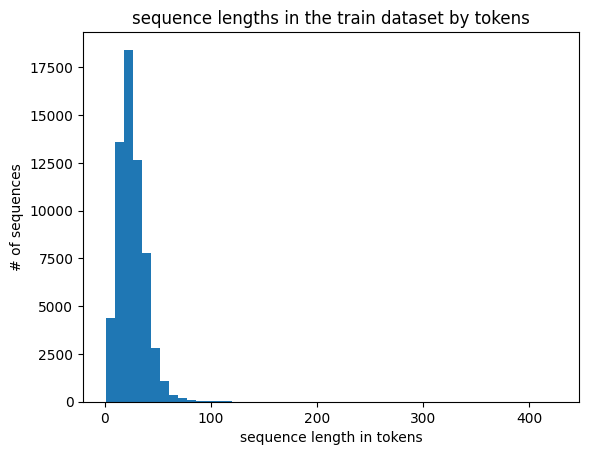

In [16]:
plt.hist([len(t) for t in tokens_train], bins=50)
plt.title('sequence lengths in the train dataset by tokens')
plt.ylabel('# of sequences')
plt.xlabel('sequence length in tokens')
plt.show()

In [17]:
# Notice above that the vast majority of sequences have less than 100 tokens.
# For performance we will thus truncate to 100 tokens.

MAX_LEN = 100
DEVICE = torch.device("mps")

data_train = torch.tensor(
    [tokenize(t, MAX_LEN) for t in lines_train if len(t) > 0],
    dtype=torch.long
)
data_val = torch.tensor(
    [tokenize(t, MAX_LEN) for t in lines_dev if len(t) > 0],
    dtype=torch.long
)

data_train.shape, data_val.shape

(torch.Size([61530, 100]), torch.Size([12216, 100]))

In [18]:
# X is all but last token, Y is all but first token
train_dataset = torch.utils.data.TensorDataset(data_train[:, :-1], data_train[:, 1:])
val_dataset = torch.utils.data.TensorDataset(data_val[:, :-1], data_val[:, 1:])

# example X,Y pair from train dataset -- 2 is <START>, 3 is <STOP>
train_dataset[447]

(tensor([    0,  3745,    11, 21457,     5,    11,     4, 11879,   165,     8,
          1732,     5,     4, 14207,  2973,  2405,    21,    31,  1372,   147,
            34,  2439,   350,    15,   382,     5,  1166,    56,    12,   233,
            13,   537,    28,    13,   681,   184,    70,   373,  1332,   270,
           318,   632,    11,     4,   739,     6,     1,     3,     3,     3,
             3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
             3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
             3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
             3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
             3,     3,     3,     3,     3,     3,     3,     3,     3]),
 tensor([ 3745,    11, 21457,     5,    11,     4, 11879,   165,     8,  1732,
             5,     4, 14207,  2973,  2405,    21,    31,  1372,   147,    34,
          2439,   350,    15,   382,     5,  1166,    56,

### Model and Trainer code

In [19]:
model_config = GPT.get_default_config()
model_config.model_type = None
model_config.pad_token = tokenizer['<PAD>']

# This configuration is the very small 'gpt-nano' defined in minGPT. we'd use a
# bigger model like 'gpt2' but it would take a very long time to train :(
# See minGPT/model.py for configurations of other models
model_config.model_type = 'gpt-nano'
# 'gpt-nano' equivalent to:
# model_config.n_layer = 3
# model_config.n_head = 3
# model_config.n_embd = 48

model_config.vocab_size = max(tokenizer.values()) + 1
# model_config.vocab_size = 50257 # openai's model vocabulary, if using gpt2 BPE

# The model's context length
# Note that minGPT has learned posemb, so outside the used maxlen wont really work
model_config.block_size = 1024

# We modified config to accept some functions for attention
# Feel free to replace either of these!
model_config.attn_init_fn = init_qkv_proj
model_config.attn_fn = self_attention

# Can use the wrapper around PyTorch's multi-head attention instead, but it's hard to modify for experiments
# model_config.attn_fn = MHA_wrapper

model = GPT(model_config)

number of parameters: 1.40M


In [20]:
train_config = Trainer.get_default_config()
train_config.device = DEVICE
train_config.num_workers = 2

# We didn't tune the hyperparameters at all, feel free to change
train_config.learning_rate = 5e-4
train_config.batch_size = 32
train_config.max_iters = len(train_dataset) // train_config.batch_size  # train for 1 epoch

trainer = Trainer(train_config, model, train_dataset)
log = []

running on device mps


In [21]:
model.to(DEVICE)
model.train()

bar = tqdm(total=train_config.max_iters)
@torch.no_grad()
def on_batch_end(trainer):
    log.append( trainer.loss.item() )
    bar.set_postfix(loss=trainer.loss.item())
    bar.update()

trainer.set_callback('on_batch_end', on_batch_end)
trainer.run()
bar.close()

100%|██████████| 1922/1922 [03:30<00:00,  9.12it/s, loss=6.02]


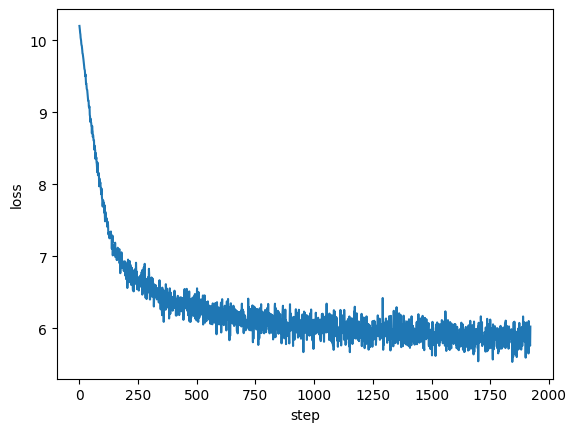

In [22]:
plt.plot(log)
plt.xlabel('step')
plt.ylabel('loss')
plt.show()

### Evaluation

Like in A1, we will treat each line in the data file as a separate document. So, compute perplexity for each line separately and then take the average across all lines.

However, the way we processed our data for batching makes it slightly more complicated, because the loss is averaged over tokens. While this would normally be simple, recall that we insert `<PAD>` tokens as padding until 100 tokens, and the vast majority of documents are significantly less than 100 tokens. This means that most of our tokens are the long tail of `<PAD>`s.

So, we wish to exlude every `<PAD>` from perplexity calculations. Since the loss returned by the model is averaged for all tokens. PyTorch has great utilities for excluding a padding token from calculations, but we will also do this manually as a demonstration.

However, this isn't the end of the story. Ideally, we would make `<PAD>` tokens have no effect whatsoever. For this to happen, we should apply a mask out all attention to and from `<PAD>` tokens, but we chose not to include that in your required implementation. The fact that we did not implement this has no measurable impact because our minGPT fork zeros out values for `<PAD>` tokens after attention anyway.

In [23]:
sentence = 'Thank you so much Liwei and Taylor for all your help with this !'

tokens = torch.tensor([tokenize(sentence, pad_to_len=MAX_LEN)], dtype=torch.long)
X_tokens, y_tokens = tokens[:, :-1], tokens[:, 1:]

print('notice the long tail of PAD tokens: ', tokens.cpu()[0].tolist())

model.eval()
with torch.no_grad():
    logits, loss = model(X_tokens.to(DEVICE), y_tokens.to(DEVICE))
    logits, loss = logits.cpu(), loss.cpu()

# Preprocess logits to unpad -- will be (jagged) list of tensors
# We impl looping over them
# students have to: convert 1 document's raw logits + y_tokens into loss and ppl

# There's more ways to get the loss!

# We could use F.cross_entropy with the logits -- this is what the model does
# F.cross_entropy can take an "ignore_index", which makes it ignore our pad token
also_loss = F.cross_entropy(logits.flatten(0,1), y_tokens.flatten(0,1),
                            ignore_index=tokenizer['<PAD>'])

# However, we can just do the calculations manually because we enjoy being perplexed

# softmax the logits to get probabilities
probs = F.softmax(logits, dim=-1)

# work with log of the probabilities for numerical stability
log_probs = torch.log(probs)

# this is weird pytorch screwery to index into last dimension of log_probs with y_tokens
# this selects only the log probabilities of the target tokens
y_log_probs = torch.gather(log_probs, -1, y_tokens[..., None])[..., 0]

# get all the target log probabilities EXCEPT for when that target token is <PAD>
not_pad_y_log_probs = y_log_probs[y_tokens != tokenizer['<PAD>']]

# negative average of the log probs of the target tokens is exactly crossentropy loss here!
also_loss_again = -not_pad_y_log_probs.mean()

print()
print('reported loss from model:\t', loss.item())
print('manually calculated loss:\t', also_loss.item())
print('manually calculated loss again:\t', also_loss_again.item())

# we can calculate perplexity using the crossentropy loss
perplexity = torch.exp(also_loss)
print('perplexity:', perplexity.item())

notice the long tail of PAD tokens:  [0, 7441, 64, 98, 149, 2, 9, 2697, 15, 72, 168, 171, 20, 46, 236, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]

reported loss from model:	 5.62632417678833
manually calculated loss:	 5.626324653625488
manually calculated loss again:	 5.626323223114014
perplexity: 277.63983154296875


In [24]:
"""
We've made a utility function to calculate loss per-document for some data.
It accepts a list of strings, tokenizes, evaluates, and returns a list of floats.
"""
@torch.no_grad
def evaluate_losses(data, model=model, bs=32, progress=True, pad_to_len=MAX_LEN):
    it = range(0, len(data), bs)
    if progress: it = tqdm(it)

    out = []
    for b_start in it:
        batch = slice(b_start, b_start+bs)
        tokens = torch.tensor(
            [tokenize(t, pad_to_len=pad_to_len) for t in data[batch]],
            dtype=torch.long).to(DEVICE)
        X_tokens, y_tokens = tokens[:, :-1].contiguous(), tokens[:, 1:].contiguous()

        model.eval()
        logits, _ = model(X_tokens)
        log_probs = F.log_softmax(logits, dim=-1)
        y_log_probs = torch.gather(log_probs, 2, y_tokens[..., None])[..., 0]

        for i in range(y_tokens.shape[0]):
            not_pad = (y_tokens[i] != tokenizer['<PAD>'])
            loss = -y_log_probs[i, not_pad].mean()
            out.append(loss.item())

    return out

In [25]:
# calculate loss and perplexity for a single sentence
loss1 = evaluate_losses(['After learning language models model natural language',], progress=False)[0]
loss2 = evaluate_losses(['The quick brown fox jumps over the lazy dog.',], progress=False)[0]
loss3 = evaluate_losses(['Amidst the twilight, the ancient ruins whispered secrets long forgotten.',], progress=False)[0]
loss4 = evaluate_losses(['Quantum entanglement fascinates physicists and philosophers alike, bridging worlds with invisible threads.',], progress=False)[0]
print('loss1:', loss1)
print('perplexity1:', np.exp(loss1))
print()
print('loss2:', loss2)
print('perplexity2:', np.exp(loss2))
print()
print('loss3:', loss3)
print('perplexity3:', np.exp(loss3))
print()
print('loss4:', loss4)
print('perplexity4:', np.exp(loss4))

loss1: 9.281942367553711
perplexity1: 10742.277115896963

loss2: 6.526523590087891
perplexity2: 683.0196232250711

loss3: 7.666393280029297
perplexity3: 2135.365872918697

loss4: 6.333707809448242
perplexity4: 563.2411176940757


In [26]:
train_losses = evaluate_losses(lines_train)
print('train perplexity:', np.mean(np.exp(train_losses)))

100%|██████████| 1923/1923 [05:44<00:00,  5.57it/s]

train perplexity: 403.9356470955477


In [27]:
dev_losses = evaluate_losses(lines_dev)
print('dev perplexity:', np.mean(np.exp(dev_losses)))

100%|██████████| 382/382 [01:16<00:00,  4.98it/s]

dev perplexity: 384.30178560672005


In [28]:
# Here's an example of generating using the model -- see generate in minGPT's model.py

sentence = ''                         # empty prompt -> sample from model at random
# sentence = 'unfortunately ,'          # can sample more negative stuff
#sentence = 'fun fact : did you know'  # AI-generated fun facts


tokens = torch.tensor([tokenize(sentence, include_stop=False)], dtype=torch.long).to(DEVICE)

for _ in range(10):
    pred = model.generate(tokens, MAX_LEN-tokens.shape[-1],
                        temperature=1.0, do_sample=True, top_k=None)

    print(decode(pred[0].tolist()))

<START> The age on evidence were nothing , United bring their 28 and he was presented in usual family . <STOP>
<START> And over the House will keep question tour by the department 's Korea , being Deal pick many months . <STOP>
<START> dramatic \ cents in the New candidates which could important decision to previously sent much on . <STOP>
<START> A eyes of photos are raped as not legitimacy of their negligence miles away . <STOP>
<START> After Somali government of print broke out are up two documentary . <STOP>
<START> Yet created Berlusconi 's even had set , handled , in our foundation . <STOP>
<START> recall each year , hard into a writing or his Logan spokeswoman in other Republican own champion who was reported the David fixtures . <STOP>
<START> Jacob after repeated <UNK> lay a single ceiling that he automatic Meyer -- with Stanley accidents , who has against 4.5 days . <STOP>
<START> Mark partial the Harman is much in Georgia and troop job and growing Jim calling and more <UNK> 